In [0]:
import numpy as np
import keras
import tensorflow as tf
from keras import models
from keras import layers
from keras.datasets import mnist
from keras import backend as K
import random

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

indexes = np.arange(x_train.shape[0])
random.seed(42)
random.shuffle(indexes)

train_val_split = int(0.8 * x_train.shape[0])
x_val = x_train[indexes[train_val_split:], :]
y_val = y_train[indexes[train_val_split:]]
x_train = x_train[indexes[:train_val_split], :]
y_train = y_train[indexes[:train_val_split]]

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

train size: 60000
test size: 60000
labels distribution: [(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]


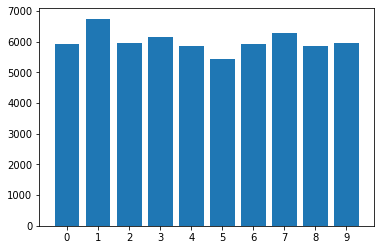

In [0]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

print('train size:', len(x_train))
print('test size:', len(x_train))
data_distribution = sorted(Counter(y_train).items())
print('labels distribution:', data_distribution)
x = np.arange(len(data_distribution))
plt.bar(x, height=[val for _, val in data_distribution])
plt.xticks(x, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

# Normalization

In [0]:
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test- mean) / std

# Networks

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=3, strides=1, input_shape=input_shape))
model.add(layers.Activation(activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1))
model.add(layers.Activation(activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1))
model.add(layers.Activation(activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
activation_10 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 8)         32        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_11 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 16)         

In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

monitor = 'loss'
early_stopping = EarlyStopping(monitor=monitor, patience=10, min_delta=0.001, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=10, verbose=1)
callbacks = [early_stopping]

history = model.fit(
  x_train, 
  y_train,
  validation_data=(x_val, y_val),
  batch_size=256,
  epochs=200,
  verbose=1,
  callbacks=callbacks
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 4s 92us/step - loss: 0.8941 - acc: 0.7221 - val_loss: 0.2662 - val_acc: 0.9202
Epoch 2/200
48000/48000 [==============================] - 3s 63us/step - loss: 0.2650 - acc: 0.9230 - val_loss: 0.1429 - val_acc: 0.9550
Epoch 3/200
48000/48000 [==============================] - 3s 61us/step - loss: 0.1829 - acc: 0.9450 - val_loss: 0.1119 - val_acc: 0.9643
Epoch 4/200
48000/48000 [==============================] - 3s 60us/step - loss: 0.1492 - acc: 0.9553 - val_loss: 0.0976 - val_acc: 0.9690
Epoch 5/200
48000/48000 [==============================] - 3s 60us/step - loss: 0.1337 - acc: 0.9593 - val_loss: 0.0905 - val_acc: 0.9699
Epoch 6/200
48000/48000 [==============================] - 3s 61us/step - loss: 0.1180 - acc: 0.9646 - val_loss: 0.0844 - val_acc: 0.9734
Epoch 7/200
48000/48000 [==============================] - 3s 61us/step - loss: 0.1103 - acc: 0.9658 - val_loss: 0.0791 - 

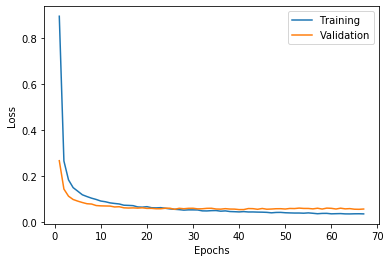

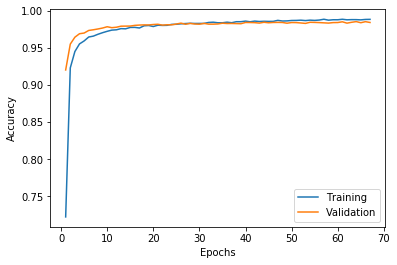

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1, len(history.history['val_acc']) + 1))

def plot_history(history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, history.history['acc'])
    plt.plot(x_plot, history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

In [28]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 95us/step


[0.054923502241638195, 0.9849]

In [29]:
from sklearn.metrics import classification_report

# labels_val_from_categorical = np.argmax(labels_val, axis=1)
predictions = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.96      0.98      0.97      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

